# Text Classification on TC32

## Analyze and Preprocess Dataset

In [1]:
from datasets import load_dataset
import pandas as pd

tc32 = pd.read_csv("../Data/TC32/ticaret-yorum.csv")

text_labels = ['kamu-hizmetleri', 'finans', 'cep-telefon-kategori', 'enerji', 'ulasim', 'kargo-nakliyat', 'medya', 'mutfak-arac-gerec', 
               'alisveris', 'mekan-ve-eglence', 'elektronik', 'beyaz-esya', 'kucuk-ev-aletleri', 'internet', 'giyim', 'etkinlik-ve-organizasyon', 
               'icecek', 'saglik', 'sigortacilik', 'spor', 'mobilya-ev-tekstili', 'otomotiv', 'turizm', 'egitim', 'gida', 'temizlik', 'hizmet-sektoru', 
               'mucevher-saat-gozluk', 'bilgisayar', 'kisisel-bakim-ve-kozmetik', 'anne-bebek', 'emlak-ve-insaat']

int_labels = list(range(32))

tc32 = tc32.rename(columns={'category': 'label'})

# Change order of columns
tc32 = tc32[['text', 'label']]

label_mapping = dict(zip(text_labels, int_labels))
tc32['label'] = tc32['label'].map(label_mapping)

# Shuffle dataset
tc32 = tc32.sample(frac=1, random_state=42).reset_index(drop=True)

display(tc32)

,text,label
0,"Ferhat Şenol Avukatlık Saygısızlık!,""0 232 287...",26
1,"Cinemaximum Ve Sinemia Haksızlığı!,""[xxx] PNR ...",15
2,"İstwest Yönetimi Çok Kötü!,Kentsel yönetimin i...",31
3,"Prestij Halı Yıkama Ankara Gölbaşı , Halımı Ya...",25
4,"Danone Hayat İçecek Vodafone Su Kampanyası,Dün...",16
...,...,...
431301,"Arzum Kalitesizliği,Arzum marka ütüyü Bursa Fu...",12
431302,Allianz Sigorta Diye Sigorta Şirketinin Yalnı...,18
431303,Shoppe Nikah Salonu Korona Sebebiyle Kına Orga...,15
431304,Ziraat Bankası Temel İhtiyaç Kredisi Sonuçları...,1



Analysis of TC 32 Dataset



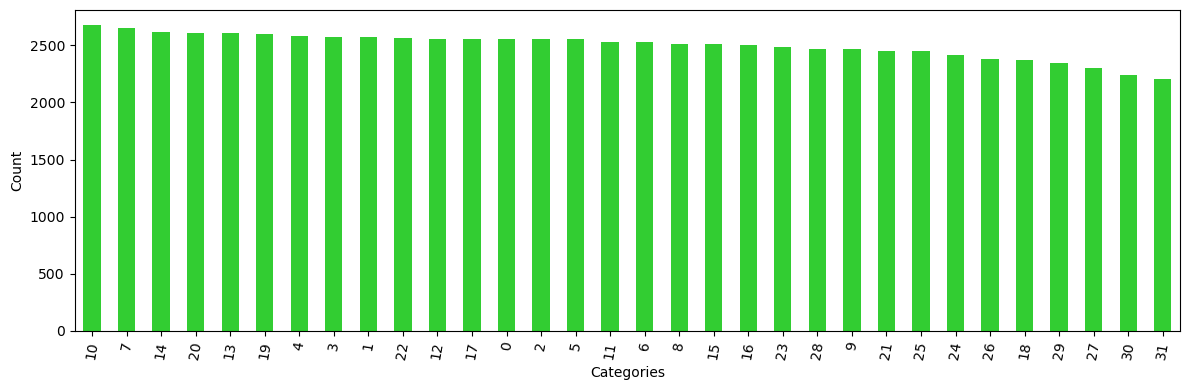


Statistical measures for input text (character-level):



,text
count,80000.00
mean,332.02
std,54.08
min,32.00
25%,323.00
50%,349.00
75%,362.00
max,796.00


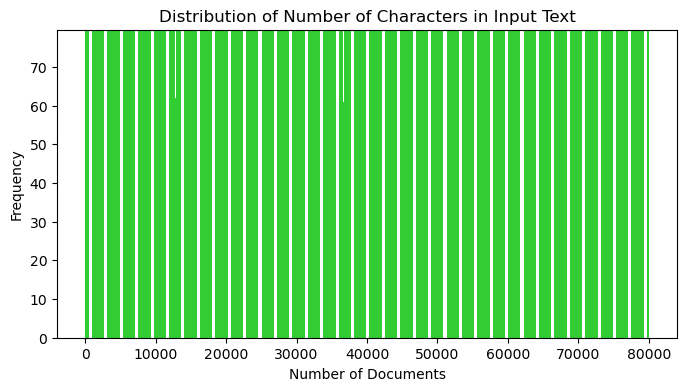

Statistical measures for input text (word-level):



,text
count,80000.00
mean,44.43
std,8.06
min,4.00
25%,42.00
50%,46.00
75%,49.00
max,98.00


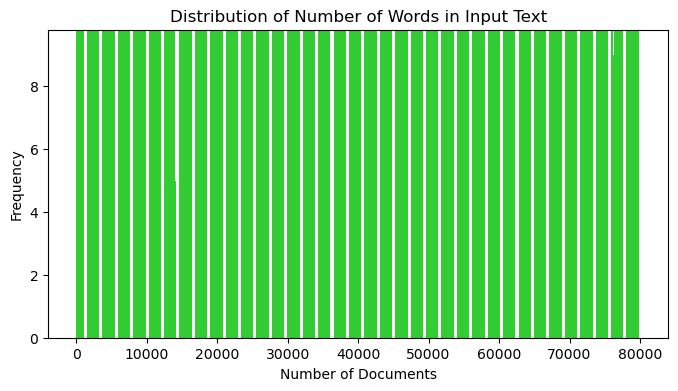

In [2]:
import sys
sys.path.append("../Helper_Functions/")

from general_utils import analyze_dataset 

analyze_dataset(tc32[:80000], 
                (12, 4), (8, 4), (8, 4), 
                0.1, 0.09,
                0.1, 0.09,
                'limegreen', 'TC 32',
               rotation=80)

## Fine Tune

In [1]:
import torch
import pandas as pd

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Preprocess Dataset

In [2]:
text_labels = ['kamu-hizmetleri', 'finans', 'cep-telefon-kategori', 'enerji', 'ulasim', 'kargo-nakliyat', 'medya', 'mutfak-arac-gerec', 
               'alisveris', 'mekan-ve-eglence', 'elektronik', 'beyaz-esya', 'kucuk-ev-aletleri', 'internet', 'giyim', 'etkinlik-ve-organizasyon', 
               'icecek', 'saglik', 'sigortacilik', 'spor', 'mobilya-ev-tekstili', 'otomotiv', 'turizm', 'egitim', 'gida', 'temizlik', 'hizmet-sektoru', 
               'mucevher-saat-gozluk', 'bilgisayar', 'kisisel-bakim-ve-kozmetik', 'anne-bebek', 'emlak-ve-insaat']

int_labels = list(range(32))
num_labels = len(text_labels)

id2label = dict(zip(int_labels, text_labels))
label2id = dict(zip(text_labels, int_labels))

print(id2label, label2id, sep="\n\n")

{0: 'kamu-hizmetleri', 1: 'finans', 2: 'cep-telefon-kategori', 3: 'enerji', 4: 'ulasim', 5: 'kargo-nakliyat', 6: 'medya', 7: 'mutfak-arac-gerec', 8: 'alisveris', 9: 'mekan-ve-eglence', 10: 'elektronik', 11: 'beyaz-esya', 12: 'kucuk-ev-aletleri', 13: 'internet', 14: 'giyim', 15: 'etkinlik-ve-organizasyon', 16: 'icecek', 17: 'saglik', 18: 'sigortacilik', 19: 'spor', 20: 'mobilya-ev-tekstili', 21: 'otomotiv', 22: 'turizm', 23: 'egitim', 24: 'gida', 25: 'temizlik', 26: 'hizmet-sektoru', 27: 'mucevher-saat-gozluk', 28: 'bilgisayar', 29: 'kisisel-bakim-ve-kozmetik', 30: 'anne-bebek', 31: 'emlak-ve-insaat'}

{'kamu-hizmetleri': 0, 'finans': 1, 'cep-telefon-kategori': 2, 'enerji': 3, 'ulasim': 4, 'kargo-nakliyat': 5, 'medya': 6, 'mutfak-arac-gerec': 7, 'alisveris': 8, 'mekan-ve-eglence': 9, 'elektronik': 10, 'beyaz-esya': 11, 'kucuk-ev-aletleri': 12, 'internet': 13, 'giyim': 14, 'etkinlik-ve-organizasyon': 15, 'icecek': 16, 'saglik': 17, 'sigortacilik': 18, 'spor': 19, 'mobilya-ev-tekstili': 2

In [6]:
# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split

# # Train %70, Val %15 and Test %15
# tc32_train, tc32_test = train_test_split(tc32, test_size=0.3, random_state=42)
# tc32_val, tc32_test = train_test_split(tc32_test, test_size=0.5, random_state=42)

In [7]:
# def undersample_data(data, samples_per_class, random_state=42):
    
#     undersampled_data = pd.DataFrame()
    
#     for label in data['label'].unique():
#         class_samples = data[data['label'] == label]
#         undersampled_class = resample(class_samples, replace=False, n_samples=samples_per_class, random_state=random_state)
        
#         undersampled_data = pd.concat([undersampled_data, undersampled_class])

#     return undersampled_data

# samples_per_class_train = 1000
# samples_per_class_val = 300
# samples_per_class_test = 300

# tc32_train = undersample_data(tc32_train, samples_per_class_train)
# tc32_val = undersample_data(tc32_val, samples_per_class_val)
# tc32_test = undersample_data(tc32_test, samples_per_class_test)  

# # Shuffle the undersampled sets
# tc32_train = tc32_train.sample(frac=1, random_state=42).reset_index(drop=True)
# tc32_val = tc32_val.sample(frac=1, random_state=42).reset_index(drop=True)
# tc32_test = tc32_test.sample(frac=1, random_state=42).reset_index(drop=True)

# tc32_train.to_csv("../Data/TC32/tc32_train_undersampled.csv", index=False)
# tc32_val.to_csv("../Data/TC32/tc32_val_undersampled.csv", index=False)
# tc32_test.to_csv("../Data/TC32/tc32_test_undersampled.csv", index=False)

In [4]:
tc32_train = pd.read_csv("../Data/TC32/tc32_train_undersampled.csv")
tc32_val = pd.read_csv("../Data/TC32/tc32_val_undersampled.csv")
tc32_test = pd.read_csv("../Data/TC32/tc32_test_undersampled.csv")

X_train = tc32_train['text'].tolist()
y_train = tc32_train['label'].tolist()

X_val = tc32_val['text'].tolist()
y_val = tc32_val['label'].tolist()

X_test = tc32_test['text'].tolist()
y_test = tc32_test['label'].tolist()

print("Train set shape      :", len(X_train), len(y_train))
print("Validation set shape :", len(X_val), len(y_val))
print("Test set shape       :", len(X_test), len(y_test))

Train set shape      : 32000 32000
Validation set shape : 9600 9600
Test set shape       : 9600 9600


### Prepare Training

In [5]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def compute_metrics(preds): 
    
    labels = preds.label_ids 
    preds = preds.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    
    return { 
        'Accuracy': acc, 
        'F1': f1, 
        'Precision': precision, 
        'Recall': recall 
    }


def predict(model, tokenizer, text):
    
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

### BERTurk

In [5]:
from transformers import BertTokenizerFast, BertForSequenceClassification

tokenizer_bert = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)
model_bert = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_encodings = tokenizer_bert(X_train, truncation=True, padding=True)
val_encodings  = tokenizer_bert(X_val, truncation=True, padding=True)
test_encodings = tokenizer_bert(X_test, truncation=True, padding=True)

from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
        
    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train)
val_dataset = MyDataset(val_encodings, y_val)
test_dataset = MyDataset(test_encodings, y_test)

#### Train

In [12]:
training_args = TrainingArguments(
    output_dir='../Models/berturk_text_classification_fine_tuned_tc32/', 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',              
    logging_dir='../Output/BERT_Logs_TC32',            
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=1,
    save_strategy="epoch",
    save_steps=1,
    fp16=True,
    load_best_model_at_end=True
)

trainer_bert = Trainer(
    model=model,                    
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

In [13]:
trainer_bert.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.267500,0.254258,0.945729,0.945650,0.946100,0.945729
2,0.122600,0.213617,0.955104,0.955180,0.955471,0.955104
3,0.038400,0.213452,0.959167,0.959162,0.959306,0.959167


TrainOutput(global_step=6000, training_loss=0.24694098095099132, metrics={'train_runtime': 1919.3174, 'train_samples_per_second': 50.018, 'train_steps_per_second': 3.126, 'total_flos': 7846111180800000.0, 'train_loss': 0.24694098095099132, 'epoch': 3.0})

#### Evaluate

In [14]:
result = [trainer_bert.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(result, index=["train", "val", "test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.025619,0.994344,0.994343,0.994352,0.994344
val,0.213452,0.959167,0.959162,0.959306,0.959167
test,0.223776,0.959583,0.959559,0.959703,0.959583


In [15]:
text = "Teknoloji mağazasından aldığım ürün sağlığımı yerle bir edip günlük hayatımız zora soktu!"
predict(text)[0]

tensor([[2.4394e-05, 2.6776e-04, 1.3039e-01, 3.1445e-05, 1.5253e-04, 1.1558e-04,
         4.5237e-04, 2.3371e-04, 8.0479e-03, 1.1536e-04, 5.9574e-03, 2.8915e-04,
         1.6662e-04, 3.5922e-03, 2.5407e-04, 4.5976e-05, 1.2794e-04, 9.2422e-05,
         2.0731e-04, 7.2401e-05, 3.5025e-04, 2.3440e-04, 3.7856e-05, 7.8976e-05,
         1.5930e-04, 1.2449e-04, 6.7288e-05, 6.5387e-04, 8.4696e-01, 1.6752e-04,
         4.6982e-04, 5.2200e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

#### Save Model

In [16]:
model_path = "berturk_text_classification_fine_tuned_tc32"

trainer_bert.save_model(model_path)
tokenizer_bert.save_pretrained(model_path)

('bert_text_classification_fine_tuned_tc32\\tokenizer_config.json',
 'bert_text_classification_fine_tuned_tc32\\special_tokens_map.json',
 'bert_text_classification_fine_tuned_tc32\\vocab.txt',
 'bert_text_classification_fine_tuned_tc32\\added_tokens.json',
 'bert_text_classification_fine_tuned_tc32\\tokenizer.json')

### TurkishBERTweet

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_tbt = AutoTokenizer.from_pretrained("VRLLab/TurkishBERTweet", max_length=128)
model_tbt = AutoModelForSequenceClassification.from_pretrained("VRLLab/TurkishBERTweet", num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at VRLLab/TurkishBERTweet and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
train_encodings = tokenizer_tbt(X_train, truncation=True, padding=True, max_length=128)
val_encodings  = tokenizer_tbt(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer_tbt(X_test, truncation=True, padding=True, max_length=128)

from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
        
    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train)
val_dataset = MyDataset(val_encodings, y_val)
test_dataset = MyDataset(test_encodings, y_test)

#### Train

In [8]:
training_args = TrainingArguments(
    output_dir='../Models/turkishbertweet_text_classification_fine_tuned_tc32/', 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',              
    logging_dir='../Output/TBT_Logs_TC32',            
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=1,
    save_strategy="epoch",
    save_steps=1,
    fp16=True,
    load_best_model_at_end=True
)

trainer_tbt = Trainer(
    model=model_tbt,                    
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

In [9]:
trainer_tbt.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.496000,0.436017,0.899479,0.899533,0.902190,0.899479
2,0.213900,0.357951,0.924479,0.924986,0.926446,0.924479
3,0.062700,0.378377,0.933646,0.933520,0.933899,0.933646


TrainOutput(global_step=6000, training_loss=0.41196086168289187, metrics={'train_runtime': 1488.899, 'train_samples_per_second': 64.477, 'train_steps_per_second': 4.03, 'total_flos': 6316366233600000.0, 'train_loss': 0.41196086168289187, 'epoch': 3.0})

#### Evaluate

In [10]:
result = [trainer_tbt.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(result, index=["train", "val", "test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.081182,0.981094,0.981114,0.981260,0.981094
val,0.357951,0.924479,0.924986,0.926446,0.924479
test,0.367598,0.924687,0.925039,0.926488,0.924687


In [11]:
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(model_tbt, tokenizer_tbt, text)[0]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor([[7.7215e-05, 5.9660e-05, 4.7495e-05, 4.5023e-05, 1.9671e-05, 1.4633e-05,
         1.6567e-04, 1.3207e-05, 1.2419e-05, 3.0039e-05, 9.9558e-05, 4.6449e-05,
         3.4676e-05, 3.3700e-05, 2.6861e-05, 3.5300e-05, 3.9747e-05, 2.8594e-05,
         3.8215e-05, 9.9861e-01, 1.3362e-05, 4.8290e-05, 6.0216e-05, 5.8317e-05,
         1.1701e-05, 3.6137e-05, 4.5199e-05, 2.0296e-05, 9.2166e-05, 1.5365e-05,
         5.2330e-05, 6.4139e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

#### Save Model

In [12]:
model_path = "turkishbertweet_text_classification_fine_tuned_tc32"

trainer_tbt.save_model(model_path)
tokenizer_tbt.save_pretrained(model_path)

('turkishbertweet_text_classification_fine_tuned_tc32\\tokenizer_config.json',
 'turkishbertweet_text_classification_fine_tuned_tc32\\special_tokens_map.json',
 'turkishbertweet_text_classification_fine_tuned_tc32\\vocab.json',
 'turkishbertweet_text_classification_fine_tuned_tc32\\merges.txt',
 'turkishbertweet_text_classification_fine_tuned_tc32\\added_tokens.json',
 'turkishbertweet_text_classification_fine_tuned_tc32\\tokenizer.json')